# Lab 05 Logistic Classification(Regression) - Eager Execution
- Logistic Classfication은 True or False와 같은 Binary나 복수개의 다항 분류에 쓰입니다 (Bernoulli Distribution)

In [10]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(777)  # for reproducibility
print(tf.__version__)

2.8.0


## Data
- x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data를 0과 1로 구분하는 예제이다.
- Logistic Classification을 통해 보라색과 노란색 y_data(Label)을 구분해 보겠다.
- Test 데이터는 붉은 색의 위치와 같이 추론시 1의 값을 가지게 된다.

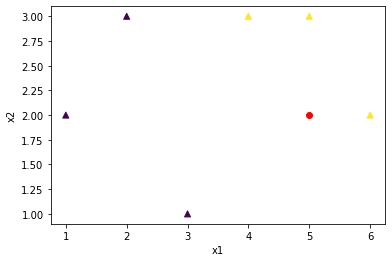

In [11]:
x_train = [[1., 2.],
          [2., 3.],
          [3., 1.],
          [4., 3.],
          [5., 3.],
          [6., 2.]]
y_train = [[0.],
          [0.],
          [0.],
          [1.],
          [1.],
          [1.]]

x_test = [[5.,2.]]
y_test = [[1.]]


x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

colors = [int(y[0] % 3) for y in y_train]
plt.scatter(x1,x2, c=colors , marker='^')
plt.scatter(x_test[0][0],x_test[0][1], c="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Tensorflow Eager
### 위 Data를 기준으로 가설의 검정을 통해 Logistic Classification을 만들자
- TensorFlow data API를 통해 학습시킬 값들을 담는다. (Batch Size는 한 번에 학습시킬 Size로 정한다)
- features, labels는 실제 학습에 쓰일 Data (연산을 위해 Type을 맞춰 준다)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))#.repeat()

-  w와 b는 학습을 통해 생성되는 모델에 쓰이는 Weight과 Bias (초기값을 variable : 0 이나 Random값으로 가능 tf.random_normal([2, 1]))

In [13]:
W = tf.Variable(tf.zeros([2,1]), name='wiegt')
b = tf.Variable(tf.zeros([1]), name='bias')

###  Sigmoid 함수를 가설로 선언한다.
- Sigmoid는 아래 그래프와 같이 0과 1의 값만 리턴한다. tf.sigmoid(tf.matmul(X,W) + b)와 같다.
$$ \begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align} $$
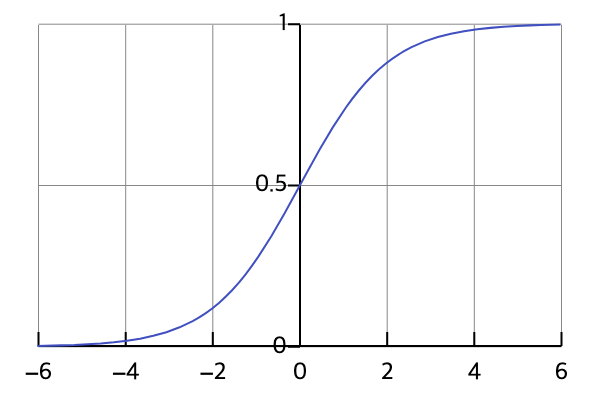

In [14]:
def logistic_regression(features):
    hypothesis  = tf.divide(1., 1. + tf.exp(tf.matmul(features, W) + b))
    return hypothesis

### 가성을 검증할 Cost 함수를 정의한다.
$$ \begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align} $$
- 위 두 수식을 합치면 아래와 같다.
$$ \begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align} $$

In [15]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(logistic_regression(features)) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

### 추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴한다.
- sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고, 0.5보다 작으면 0을 반환한다.
- 가설을 톻애 실제 값과 비교한 정확도를 측정한다

In [16]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.int32))
    return accuracy

### GradientTape를 통해 경사값을 계산합니다.


In [17]:
def grad(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features),features,labels)
    return tape.gradient(loss_value, [W,b])

## 학습을 실행한다.
- 위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성한다.
- 새로운 Data를 통한 검증 수행 [5,2]의 Data로 테스트 수행 (그래프상 1이 나와야 정상이다.)

In [18]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels  in iter(dataset):
        grads = grad(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(logistic_regression(features),features,labels)))
test_acc = accuracy_fn(logistic_regression(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 0.6874
Iter: 100, Loss: 0.5776
Iter: 200, Loss: 0.5349
Iter: 300, Loss: 0.5054
Iter: 400, Loss: 0.4838
Iter: 500, Loss: 0.4671
Iter: 600, Loss: 0.4535
Iter: 700, Loss: 0.4420
Iter: 800, Loss: 0.4319
Iter: 900, Loss: 0.4228
Iter: 1000, Loss: 0.4144
Testset Accuracy: 1.0000
